# Analyzing Rat Skull Shapes Over Time using Geodesic Regression


$\color{#003660}{\text{Nina Miolane - Assistant Professor}}$ @ Geometric Intelligence Lab @ UCSB ECE


In this tutorial, we show how to use [`geomstats`](https://github.com/geomstats/geomstats) to perform a shape data analysis. 

Specifically, we aim to study the shape of rat skulls over time.

<center><img src="figures/rat_skull_yz_view.png" width=450px alt="default"/></center>

---
### Resources

Mathematics:
- Geometric and code
    - https://hal.science/hal-03766900/
- Kendall Shape Spaces: 
    - http://image.diku.dk/imagecanon/material/kendall-shapes.pdf
- Curve Shapes:
    - https://arxiv.org/abs/1803.10894
- Surface Shapes:
    - https://arxiv.org/abs/1910.02045
- Deformations:
    - https://en.wikipedia.org/wiki/Large_deformation_diffeomorphic_metric_mapping
 
      
---

# Background

### Supervised Learning in ML

Machine Learning is divided into two principal categories of algorithms: supervised and unsupervised learning algorithms. Both learn from data.

$\color{#EF5645}{\text{Definition}}$: _Supervised learning_ refers to the task of learning a function that maps an input $X$ to an output $Y$ based on example input-output pairs. We say that the method is:
- a _classification_ if the outputs are categorical,
- a _regression_ if the outputs are quantitative.

<center><img src="figures/supervised_learning.png" width=900px alt="default"/></center>
<center>Supervised Learning</center>

### Review of Traditional Regression



$\color{#EF5645}{\text{Given data}}$:
- $(X_1, ..., X_n)$:
  - inputs, e.g. ages of the rats, in days.
- $(y_1, ..., y_n)$: 
  - outputs, e.g. rat skull shapes.



<center><img src="figures/linear_regression.png" width=450px alt="default"/></center>
<center>Inputs: $X_1, ..., X_n \in \mathbb{R}$. Outputs $y_1, ..., y_n \in \mathbb{R}$.</center>


$\rightarrow \color{#EF5645}{\text{Goal}}$: Build $f$ that predicts the rat skull shape corresponding to a new time $X_\text{new}$.


### Review of Traditional Regression: __4 Steps__

1. $\color{#EF5645}{\text{Modelling:}}$


- $\color{#EF5645}{\text{Decide on the function } f_\theta:}$ that outputs $\hat y = f_\theta(X)$: prediction for $y$.
  - $X$: input, e.g. time
  - $y$: ground truth, e.g. true rat skull at this time
  - $\hat y = f_\theta(X)$: model's predicted skull.
- $\color{#EF5645}{\text{Decide on a loss function:}}$ $L(y, \hat y)$ that evaluates if the model is right or wrong.

$\color{#047C91}{\text{Example}}$: 
- The model $f_\theta(X) = \theta_0 + \theta_1 X$ has parameters $\theta=(\theta_0, \theta_1)$.
- The loss function $L(y, \hat y) = d^2(y, \hat y)$ with $d$ is a notion of distance on shape spaces.
  - e.g. $L(y, \hat y)= |y - \hat y |^2 = |y - \theta_0 - \theta_1 X |^2$: least-squares.


2. $\color{#EF5645}{\text{Split dataset into train / test sets:}}$ 
   - Train $(X_1, y_1), ..., (X_{n_\text{train}}, y_{n_\text{train}})$: build the algorithm
   - Test $(X_{n_\text{train}+1}, y_{n_\text{train}+1}), ..., (X_n, y_n)$: assess its performances.
   
3. $\color{#EF5645}{\text{Train:}}$ Build the algorithm
   - Also called: "Fitting the model's parameters $\theta$."
   - Find $\theta^*$ such that the model predicts the train set best: 
   $$\theta^* = \text{argmin}_\theta \sum_{i=1}^{n_\text{train}} L(y_i, f_\theta(X_i))$$
   
4. $\color{#EF5645}{\text{Test:}}$ Assess its performances: 
   - Loss on test set: $\sum_{i=n_\text{train}+1}^{n} L(y_i, f_{\theta^*}(X_i))$

# Motivation: Regression of Rat Skulls Shapes

## Rat Skulls

Animal models continue to be important tools for understanding disease mechanisms and for preclinical testing of potential therapeutics. 

The rat has a large brain and exhibits a complex behavioral repertoire that make it amenable for laboratory research.

We are interested in modeling the evolution of rat skulls shapes, in order to (later) evaluate if new rats have morphological issues at development.

<center><img src="figures/rat_skull_yz_view.png" width=400px alt="default"/></center>

<center>8 landmarks on a rat's skull.</center>

### Motivation: Shape of Rat Skulls Through Time

$\color{#EF5645}{\text{Question}}$: Given rat skulls at different time points, can we predict the skull shape of that rat at another time?

$\color{#EF5645}{\text{Our answer}}$: Regression on manifold:
- __input:__ X = time in days: is a real number.
- __output:__ y is a skull shape, represented in Kendall shape space with 8 landmarks.


We will need to perform automatic differentiation: we take autograd backend.

In [1]:
import os

os.environ["GEOMSTATS_BACKEND"] = "autograd"

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import geomstats.backend as gs
import geomstats.datasets.utils as data_utils

### Data

We use Vilmann’s rat calvaria (skulls excluding the lower jaw) from X-ray images:
  - 18 rats
  - 8 time points: at ages of 7, 14, 21, 30, 40, 60, 90, and 150 days.
  - 8 landmarks in 2D for each skull shape.


In [3]:
data = data_utils.load_rat_skulls()
data_first = data[:8]
print(
    f"The data of the first rat has shape (n_times, n_landmarks, dim) = {data_first.shape}."
)

The data of the first rat has shape (n_times, n_landmarks, dim) = (8, 8, 2).


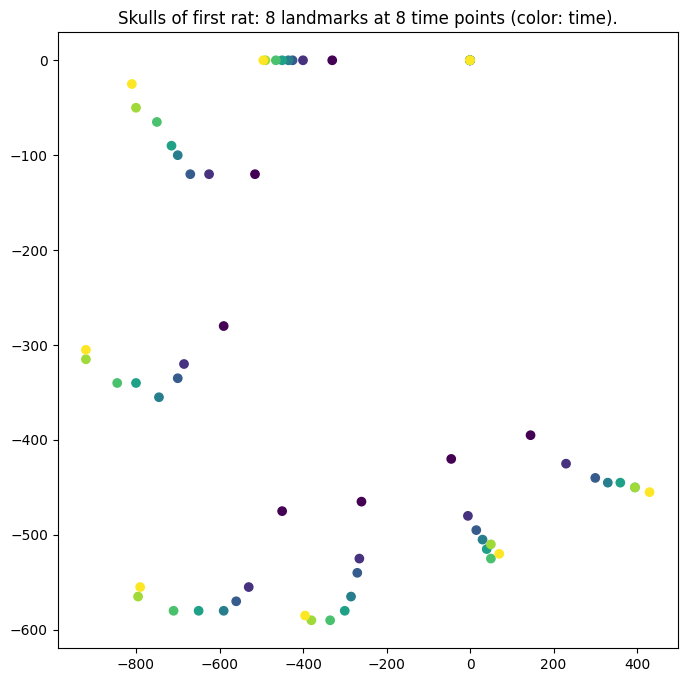

In [4]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = data_first.reshape(-1, 2)
colors = gs.repeat(gs.arange(0, 8, 1), 8)
norm = mpl.colors.Normalize(vmin=0, vmax=8)
plt_plot = plt.scatter(points[:, 0], points[:, 1], c=norm(colors))
ax.set_title("Skulls of first rat: 8 landmarks at 8 time points (color: time).");

## Regression Method 1: Tangent Machine Learning

### Recall: Tangent Space at the Fréchet Mean

The Fréchet mean gives us a way of transforming our non-linear data into vectors!
1. Compute the Fréchet mean $\bar{x}$ of the data points
2. Consider the tangent space $T_\bar{x}M$of the manifold $M$ at $\bar{x}$
3. Compute the Logarithms of the data points at $\bar{x}$

$\rightarrow$ Get a dataset on a vector space, and apply classical machine learning on it.

$\color{#EF5645}{\text{In practice}}$: 
- Either use `FrechetMean` and `metric.log` methods.
- Or the function `ToTangentSpace` does both.

1. $\color{#EF5645}{\text{Modelling:}}$

- $\color{#EF5645}{\text{Decide on the function $f_\theta$:}}$ that outputs $\hat y = f_\theta(X)$: prediction for $y$.
- $\color{#EF5645}{\text{Decide on a loss function:}}$ $L(y, \hat y)$ that evaluates if the model is right or wrong.

$\color{#047C91}{\text{Example}}$: 
- Use `ToTangentSpace` (do it manually here, with `FrechetMean`, `metric.log`)
- Use any regressor from `scikit-learn`, e.g. `LinearRegression`.
  - `LinearRegression` comes with its loss function.

In [5]:
from sklearn.linear_model import LinearRegression

from geomstats.geometry.pre_shape import PreShapeSpace
from geomstats.learning.frechet_mean import FrechetMean

preshape = PreShapeSpace(k_landmarks=8, ambient_dim=2)

preshape.equip_with_group_action("rotations")
preshape.equip_with_quotient()


kendall_shape = preshape.quotient
kendall_metric = kendall_shape.metric


mean = FrechetMean(space=kendall_shape)


lr = LinearRegression()

2. $\color{#EF5645}{\text{Split dataset into train / test sets:}}$ 
   - Train $(X_1, y_1), ..., (X_{n_\text{train}}, y_{n_\text{train}})$: build the algorithm
   - Test $(X_{n_\text{train}+1}, y_{n_\text{train}+1}), ..., (X_n, y_n)$: assess its performances.

In [6]:
from sklearn.model_selection import train_test_split

X = gs.linspace(0.0, 1.0, 8)
X = gs.to_ndarray(X, to_ndim=2).T
y = preshape.projection(data_first)
X_train, X_test, y_train, y_test = train_test_split(X, y)

print(f"The dataset has {len(X)} skulls.")
print(f"The train set has {len(X_train)} skulls.")
print(f"The test set has {len(X_test)} skulls.")

The dataset has 8 skulls.
The train set has 6 skulls.
The test set has 2 skulls.


3. $\color{#EF5645}{\text{Train:}}$ Build the algorithm
   - Also called: "Fitting the model's parameters $\theta$."
   - Find $\theta^*$ such that the model predicts the train set best: 
   $$\theta^* = \text{argmin}_\theta \sum_{i=1}^{n_\text{train}} L(y_i, f_\theta(X_i))$$

In [7]:
from geomstats.learning.frechet_mean import FrechetMean

mean.fit(y_train)

tangent_y_train = kendall_metric.log(y_train, base_point=mean.estimate_)
tangent_y_test = kendall_metric.log(y_test, base_point=mean.estimate_)

In [8]:
lr.fit(X_train, tangent_y_train.reshape((6, -1)))

LinearRegression()

4. $\color{#EF5645}{\text{Test:}}$ Assess its performances: 
   - Loss on test set: $\sum_{i=n_\text{train}+1}^{n} L(y_i, f_{\theta^*}(X_i))$

In [9]:
print(tangent_y_test.shape)
score = lr.score(X_test, tangent_y_test.reshape((2, -1)))
print(f"We get a score of {score:.2f}.")

(2, 8, 2)
We get a score of -5.25.


Best possible score is 1, and the score can be negative because it can be arbitrarily bad.

Since, we can use any regressor available in `scikit-learn`: not necessarily the `LinearRegression` regressor, we re-run with `RandomForestRegressor`.

In [10]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()

rfr.fit(X_train, tangent_y_train.reshape((6, -1)))

score = rfr.score(X_test, tangent_y_test.reshape((2, -1)))

print(f"R^2 score: {score:.2f}.")

R^2 score: -2.63.


This is still not great: let's try to do geometric machine learning.

# Regression Method 2: Geodesic Regression


### Why another regression method?

$\color{#EF5645}{\text{Previous subsection}}$: Regression Method 1:
- "Project" data on the tangent space at the FrechetMean: `ToTangentSpace`.
- Apply a traditional regression: e.g. `LinearRegression` or `RandomForestRegressor`.

However, projecting the data on the tangent space deforms their distribution: the geometry of the curved manifold affects the traditional regression results.

$\color{#EF5645}{\text{This subsection}}$: Regression Method 2:
- Keep data on the manifold with geodesic regression

## From Linear to Geodesic Regression

We explain geodesic regression by generalizing concepts from linear regression.

<center><img src="figures/linear_vs_geodesic_regressions.png" width=900px alt="default"/></center>

## From Linear to Geodesic Regression: Function $f$

1. $\color{#EF5645}{\text{Modelling:}}$
- $\color{#EF5645}{\text{Decide on the function } f_\theta:}$ that outputs $\hat y = f_\theta(X)$: prediction for $y$.
- $\color{#EF5645}{\text{Decide on a loss function:}}$ $L(y, \hat y)$ that evaluates if the model is right or wrong.


The linear regression model with $\theta_0, \theta_1 \in \mathbb{R}^m$:

$$f_\theta(X) = \theta_0 + \theta_1 X \in \mathbb{R}^m$$ 

Becomes a geodesic regression model with $\theta_0 \in M$ and $\theta_1 \in T_{\theta_0}M$:

$$f_\theta(X) = \text{Exp}_{\theta_0}\left( \theta_1 X \right) \in M,$$
where Exp is the Riemannian exponential.

## From Linear to Geodesic Regression: Loss $L$

1. $\color{#EF5645}{\text{Modelling:}}$
- $\color{#EF5645}{\text{Decide on the function } f_\theta:}$ that outputs $\hat y = f_\theta(X)$: prediction for $y$.
- $\color{#EF5645}{\text{Decide on a loss function:}}$ $L(y, \hat y)$ that evaluates if the model is right or wrong.


The loss function of linear regression is the squared Euclidean distance in $\mathbb{R}^m$:
$$L(y, \hat y)= |y - \hat y |^2 = |y - \theta_0 - \theta_1 X |^2$$
which becomes the square geodesic distance on $M$:
$$L(y, \hat y)= d_M(y, \hat y )^2 = d_M(y, \text{Exp}_{\theta_0}\left( \theta_1 X \right)  )^2.$$


1. $\color{#EF5645}{\text{Modelling:}}$

- $\color{#EF5645}{\text{Decide on the function } f_\theta:}$ that outputs $\hat y = f_\theta(X)$: prediction for $y$.
- $\color{#EF5645}{\text{Decide on a loss function:}}$ $L(y, \hat y)$ that evaluates if the model is right or wrong.
  - `GeodesicRegression` comes with its loss function.

In [11]:
from geomstats.learning.geodesic_regression import GeodesicRegression

# Instantiate estimator
gr = GeodesicRegression(
    space=kendall_shape,
    center_X=False,
    method="riemannian",
    initialization="warm_start",
)


# Warm-start
gr.intercept_ = y_train[0]  # theta0
gr.coef_ = kendall_metric.log(y_train[-1], y_train[0])  # theta1

3. $\color{#EF5645}{\text{Train:}}$ Build the algorithm
   - Also called: "Fitting the model's parameters $\theta$."


In [12]:
gr.fit(gs.squeeze(X_train), y_train)

GeodesicRegression(center_X=False, initialization='warm_start',
                   method='riemannian',
                   space=<geomstats.geometry.pre_shape.PreShapeSpace object at 0x7dbb6d8130b0>)

4. $\color{#EF5645}{\text{Test:}}$ Assess its performances: 
   - Loss on test set: $\sum_{i=n_\text{train}+1}^{n} L(y_i, f_{\theta^*}(X_i))$

In [13]:
print("R^2:", gr.score(gs.squeeze(X_test), y_test))

R^2: 0.7439065105861071


In this case, computing with the data on the manifold directly gives _much_ better results.

Recall our question.

$\color{#EF5645}{\text{Question}}$: Given skulls of a rat through time, can we predict what is the skull shape of that rat at another time?

We can use the fitted model to make new predictions.

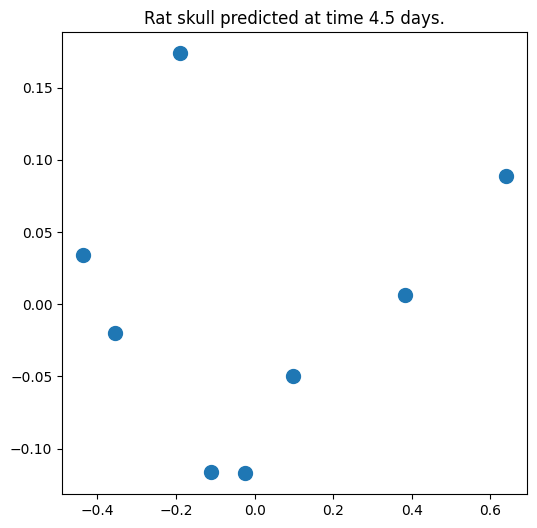

In [14]:
skull = gr.predict(gs.array([4.5]))
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
points = skull.reshape(-1, 2)
(plt_plot,) = plt.plot(points[:, 0], points[:, 1], "o", markersize=10)
ax.set_title("Rat skull predicted at time 4.5 days.");